In [877]:
import read
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib
from collections import defaultdict
import math
import copy

def process_data(path):
    data_path = f'../datasets/{path}.data'
    scheme_path = f'../datasets/{path}.names'
    # df = pd.read_csv("test_data_path")
    data, attributes, value_type = read.read(data_path, scheme_path)
    return data , attributes , value_type

def convertClusters(arr):
    mapping = {-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}
    temp = []
    for i in arr:
#         temp.append(mapping[i])
        temp.append(i+1)
    return np.array(temp)

def getAccuracy(eps, min_samples):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X_principal)
    labels_1 = db.labels_
    temp_labels = convertClusters(labels_1)
    return round(accuracy_score(temp_labels, np.array(finalDF["class"]))*100, 2)

In [878]:
def select(neighbours) :
    """
        select the not visited record with maximum neighbours
    """
    maxsub = -1
    max_neighbours_num = 0

    for k, v in neighbours.items() :
        if v['c'] == -2 :
            if v['m'] > max_neighbours_num :
                maxsub = k
                max_neighbours_num = v['m']

    #print "SELECT:", maxsub, max_neighbours_num
    return maxsub

In [879]:
def distance(a, b, gauss=True):
    """
        Euclidean distance or gauss kernel
    """
    dim = len(a)
    
    _sum = 0.0
    for dimension in range(dim):
        difference_sq = (a[dimension] - b[dimension]) ** 2
        _sum += difference_sq

    if gauss :
        dis = 1 - math.exp(_sum * -1/2)
    else :
        dis = math.sqrt(_sum)

    return dis

In [880]:
def neighbour(data, count, eps, gauss=True) :
    """
        Calculate all pair distances between records
        'c' : -2 not visited, -1 : noise, >=0 cluster id
    """
    neighbours = defaultdict(lambda : {'n' : set(), 'l' : '', 'c' : -2, 'm' : 0})

    length = count

    for i in range(length - 1) :
        for j in range(i + 1, length) :
            dis = distance(data[i]['f'], data[j]['f'], gauss)
            if dis <= eps :
                neighbours[i]['n'].add(j)
                neighbours[j]['n'].add(i)

    for i in range(length) :
        neighbours[i]['l'] = data[i]['l']
        neighbours[i]['m'] = len(neighbours[i]['n'])

        # NOISE
        if neighbours[i]['m'] == 0 :
            neighbours[i]['c'] = -1 

        #print i, neighbours[i]['m']

    return neighbours

In [881]:
def dbscan(file_name, gauss, eps, minpts) :
    """
        dbscan
    """
    data, count = load_file(file_name)
    neighbours = neighbour(data, count, eps, gauss)

    while True :  
        point = select(neighbours)
        if point < 0 :
            break

        if neighbours[point]['m'] >= minpts :
            neighbours[point]['c'] = point
            expand_dbscan(neighbours, point, minpts)
        else :
            neighbours[point]['c'] = -1
            for k, v in neighbours.items() :
                if v['c'] == -2 :
                    neighbours[k]['c'] = -1

    return evaluate(neighbours)

In [882]:
def load_file(file_name) :
    """
        Load dataset, for iris dataset
        @return data, count
        count : the records num 
        data : {'f' : feature list , 'l' : origin cluster label}
    """
    data = {}

    count = 0
    with open(file_name) as fp :
        for line in fp :
            line = line.strip()
            if len(line) < 1 :
                continue

            tokens = line.split(',')
            if len(tokens) < 2 :
                continue
            #this last column is label
            data[count] = {'f' : [float(x) for x in tokens[:-1]], 'l' : tokens[-1]}
            count += 1

    return data, count

In [883]:
def expand_dbscan(neighbours, point, minpts) :
    """
        expand the core point
    """
    candidate = copy.deepcopy(neighbours[point]['n'])

    while len(candidate) > 0:
        p = candidate.pop()
        if neighbours[p]['c'] > -1 :
            continue

        neighbours[p]['c'] = point
        if neighbours[p]['m'] >= minpts :
            candidate.union(neighbours[p]['n'])

In [884]:
def evaluate(data) :
    """
        evaluate precision and recall
    """
    stat = defaultdict(lambda : defaultdict(lambda : 0))
    for k, v in data.items() :
        stat[v['c']][v['l']] += 1

    wholecount = 0
    wholecorrect = 0
    norecall = 0
    CORR = 0
    for k, v in stat.items() :
        allcount = 0
        maxj = 0
        maxi = ''
        for i, j in v.items() :
            allcount += j
            if j > maxj :
                maxj = j
                maxi = i


        if k != -1 :
            wholecorrect += maxj
            wholecount += allcount
        else :
            norecall += allcount
#         print("AAAA:", allcount)
        CORR += maxj
        print ("CLUSTER: %d ALLNUM: %d CORRECT: %d PRECISION: %.4f LABEL: %s" % (k, allcount, maxj, float(maxj) / allcount, maxi))

    return CORR
#     print(wholecount, norecall)
#     print ("ALLNUM: %d CORRECT: %d PRECISION: %.4f RECALL: %.4f" % (wholecount + norecall, wholecorrect, float(wholecorrect) / wholecount, 1 - float(norecall) / (wholecount + norecall)))


# Dataset = seeds

In [914]:
path = 'seeds'
data , attributes , value_type = process_data(path)

In [915]:
df = pd.DataFrame.from_records(data)
df.columns = attributes

In [916]:
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [917]:
X = df.drop(df.columns[-1], axis=1)
Y = df.iloc[:, -1]

In [918]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
df.iloc[:, -1] = pd.factorize(df.iloc[:, -1])[0]
X_test = X
y_test = Y

In [919]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   area                     210 non-null    float64
 1   perimeter                210 non-null    float64
 2   compactness              210 non-null    float64
 3   length of kernel         210 non-null    float64
 4   width of kernel          210 non-null    float64
 5   asymmetry coefficient    210 non-null    float64
 6   length of kernel groove  210 non-null    float64
 7   class                    210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.2 KB


## PCA dimension reduction (to 2) for graph visualization

In [920]:
pca = PCA(n_components=2)
pca.fit(X_test)

PCA(n_components=2)

In [921]:
dfred = pca.transform(X_test)

In [922]:
finalDF = pd.DataFrame({'col 1': dfred[:, 0], 'col 2': dfred[:, 1], 'class': y_test})
# finalDF.iloc[:, -1] = finalDF.iloc[:, -1].astype('int')
finalDF.iloc[:, -1] = pd.factorize(finalDF.iloc[:, -1])[0]

In [923]:
finalDF.head()

,col 1,col 2,class
0,0.663448,-1.417321,0
1,0.315667,-2.689229,0
2,-0.660499,-1.131506,0
3,-1.055276,-1.621190,0
4,1.619999,-2.183384,0


Text(0.5, 1.0, 'Seeds dataset points')

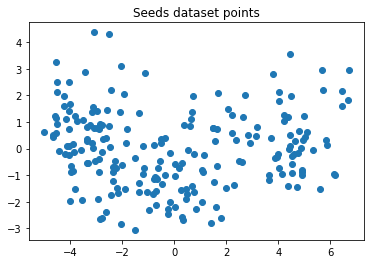

In [924]:
plt.scatter(dfred[:,0], dfred[:,1])
plt.title("Seeds dataset points")

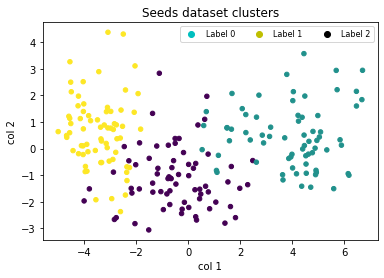

In [925]:
ax1 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c='class',
                           legend=True,
                           title="Seeds dataset clusters",
                          colorbar=False,
...                       colormap='viridis')
ax1.legend([c, y, k],
           ('Label 0', 'Label 1', 'Label 2'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

In [897]:
len(finalDF["class"])

210

# DBscan

In [898]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [899]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
print(X_principal.head())

         P1        P2
0  0.313082  0.664170
1  0.028853  0.872234
2 -0.181615  0.781382
3 -0.251413  0.830340
4  0.500380  0.819877


In [900]:
db_default = DBSCAN(eps = 0.2, min_samples = 20).fit(X_principal)
labels = db_default.labels_

In [901]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1,  1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,
        0, -1, -1,  0,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  1, -1,  1,  1])

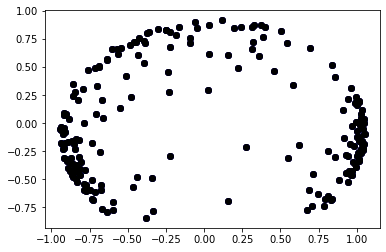

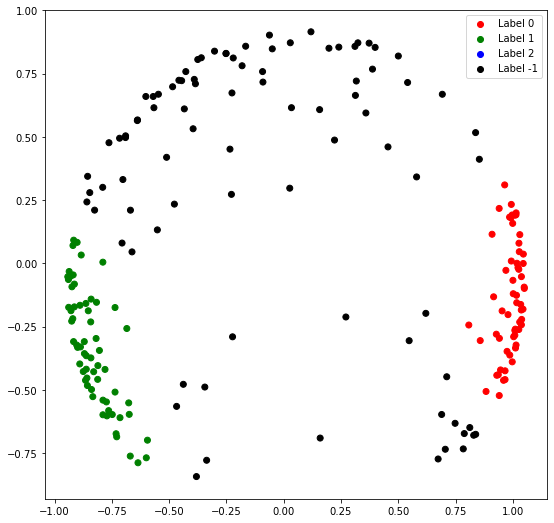

In [902]:
# Building the label to colour mapping
colours = {}
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[3] = 'y'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]
  
# For the construction of the legend of the plot
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r');
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g');
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b');
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k');
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis 
# according to the colour vector defined
plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
  
# Building the legend
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1'))
  
plt.show()

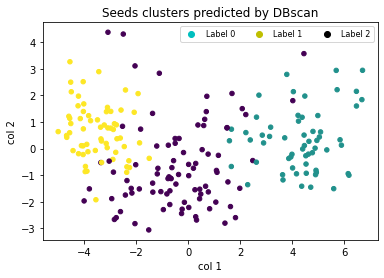

In [903]:
ax2 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c=labels,
                           legend=True,
                           title="Seeds clusters predicted by DBscan",
                          colorbar=False,
...                       colormap='viridis')
ax2.legend([c, y, k],
           ('Label 0', 'Label 1', 'Label 2'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

In [548]:
db_default.get_params()

{'algorithm': 'auto',
 'eps': 0.2,
 'leaf_size': 30,
 'metric': 'euclidean',
 'metric_params': None,
 'min_samples': 20,
 'n_jobs': None,
 'p': None}

## tuning model parameters

In [549]:
acc_df = pd.crosstab(np.array(finalDF["class"]), labels, rownames=["labels"], colnames=["cluster"])

In [552]:
def convertClusters(arr):
    mapping = {-1: 0, 0: 1, 1: 2, 2: 3, 3: 4}
    temp = []
    for i in arr:
        temp.append(mapping[i])
    return np.array(temp)

def getAccuracy(eps, min_samples):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X_principal)
    labels_1 = db.labels_
    acc_df = pd.crosstab(np.array(finalDF["class"]), labels_1, rownames=["labels"], colnames=["cluster"])
    m = 0
    for i in range(len(acc_df)):
        m += max(acc_df.iloc[i])
    return round(m/210 * 100, 2), acc_df

In [550]:
acc_df

cluster,-1,0,1
labels,,,
0,64,2,4
1,13,57,0
2,11,0,59


In [ ]:
db = DBSCAN(eps = 0.3575, min_samples = 10).fit(X_principal)
labels1 = db.labels_

In [516]:
labels1

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

In [517]:
np.array(finalDF["class"])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

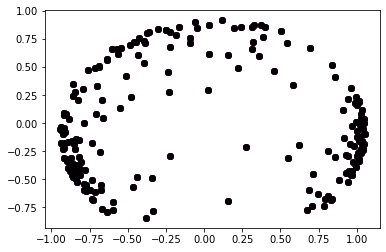

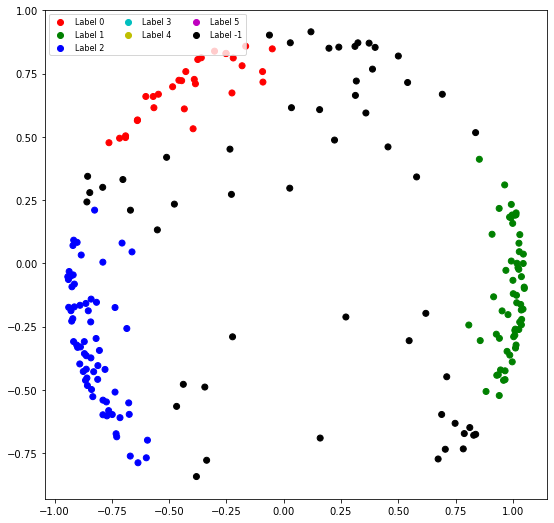

In [518]:
colours1 = {}
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'
  
cvec = [colours1[label] for label in labels]
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ]
  
r = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[0])
g = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[1])
b = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[2])
c = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[3])
y = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[4])
m = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[5])
k = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[6])
  
plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
plt.legend((r, g, b, c, y, m, k),
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label -1'),
           scatterpoints = 1,
           loc ='upper left',
           ncol = 3,
           fontsize = 8)
plt.show()

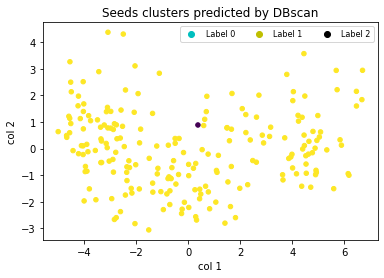

In [519]:
ax2 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c=labels1,
                           legend=True,
                           title="Seeds clusters predicted by DBscan",
                          colorbar=False,
...                       colormap='viridis')
ax2.legend([c, y, k],
           ('Label 0', 'Label 1', 'Label 2'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

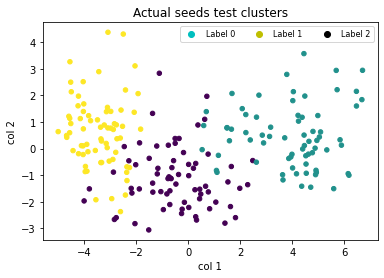

In [520]:
ax3 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c='class',
                          legend=True,
                          title="Actual seeds test clusters",
                          colorbar=False,
...                       colormap='viridis')
ax3.legend([c, y, k],
           ('Label 0', 'Label 1', 'Label 2'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

## testing with different min_samples

In [719]:
accuracyResults_samples = []
for i in range(1, 30):
    acc = dbscan('../datasets/seeds.data', True, 0.3575, i)
    accuracyResults_samples.append(round(acc/len(finalDF) * 100, 2))
#     accuracyResults_samples.append(getAccuracy(0.3575, i))

CLUSTER: 0 ALLNUM: 10 CORRECT: 8 PRECISION: 0.8000 LABEL: 1
CLUSTER: 5 ALLNUM: 18 CORRECT: 18 PRECISION: 1.0000 LABEL: 1
CLUSTER: 68 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 40 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 4 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 36 ALLNUM: 4 CORRECT: 3 PRECISION: 0.7500 LABEL: 1
CLUSTER: 6 ALLNUM: 8 CORRECT: 7 PRECISION: 0.8750 LABEL: 1
CLUSTER: 8 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 10 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 1
CLUSTER: 29 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 1
CLUSTER: 19 ALLNUM: 7 CORRECT: 4 PRECISION: 0.5714 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: 143 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 3
CLUSTER: 23 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 1
CLUSTER: 199 ALLNUM: 5 CORRECT: 4 PRECISION: 0.8000 LABEL: 3
CLUSTER: 30 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 31 ALLNUM: 1 CORRECT: 1 PREC

CLUSTER: 0 ALLNUM: 10 CORRECT: 8 PRECISION: 0.8000 LABEL: 1
CLUSTER: 5 ALLNUM: 18 CORRECT: 18 PRECISION: 1.0000 LABEL: 1
CLUSTER: 68 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 40 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 55 CORRECT: 24 PRECISION: 0.4364 LABEL: 2
CLUSTER: 6 ALLNUM: 8 CORRECT: 7 PRECISION: 0.8750 LABEL: 1
CLUSTER: 29 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 1
CLUSTER: 19 ALLNUM: 7 CORRECT: 4 PRECISION: 0.5714 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: 143 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 3
CLUSTER: 199 ALLNUM: 5 CORRECT: 4 PRECISION: 0.8000 LABEL: 3
CLUSTER: 192 ALLNUM: 6 CORRECT: 5 PRECISION: 0.8333 LABEL: 3
CLUSTER: 121 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 2
CLUSTER: 74 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 106 ALLNUM: 21 CORRECT: 21 PRECISION: 1.0000 LABEL: 2
CLUSTER: 109 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 111 ALLNUM: 3 CORR

CLUSTER: -1 ALLNUM: 165 CORRECT: 70 PRECISION: 0.4242 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: 106 ALLNUM: 21 CORRECT: 21 PRECISION: 1.0000 LABEL: 2
CLUSTER: -1 ALLNUM: 186 CORRECT: 70 PRECISION: 0.3763 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 186 CORRECT: 70 PRECISION: 0.3763 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 186 CORRECT: 70 PRECISION: 0.3763 LABEL: 1
CLUSTER: 144 ALLNUM: 24 CORRECT: 24 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1


Text(0.5, 1.0, 'Seed dataset accuracy with DBscan')

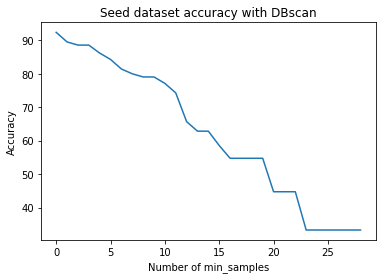

In [720]:
plt.plot(accuracyResults_samples)
plt.xlabel("Number of min_samples")
plt.ylabel("Accuracy")
plt.title("Seed dataset accuracy with DBscan")

## testing with different eps

In [709]:
accuracyResults_eps = []
for i in range(1, 70):
    acc = dbscan('../datasets/seeds.data', True, i/100, 10)
    accuracyResults_eps.append(round(acc/len(finalDF) * 100, 2))
#     accuracyResults_eps.append(getAccuracy(i/100, 10))

CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 2
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 L

CLUSTER: 47 ALLNUM: 8 CORRECT: 7 PRECISION: 0.8750 LABEL: 1
CLUSTER: 24 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 1
CLUSTER: 21 ALLNUM: 17 CORRECT: 17 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 88 CORRECT: 40 PRECISION: 0.4545 LABEL: 2
CLUSTER: 69 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 1
CLUSTER: 144 ALLNUM: 22 CORRECT: 22 PRECISION: 1.0000 LABEL: 3
CLUSTER: 200 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 3
CLUSTER: 192 ALLNUM: 9 CORRECT: 8 PRECISION: 0.8889 LABEL: 3
CLUSTER: 121 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 2
CLUSTER: 106 ALLNUM: 19 CORRECT: 19 PRECISION: 1.0000 LABEL: 2
CLUSTER: 96 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 159 ALLNUM: 10 CORRECT: 10 PRECISION: 1.0000 LABEL: 3
CLUSTER: 177 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 3
CLUSTER: 48 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 1
CLUSTER: 24 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 89 CORRECT: 44 PRECISION: 0.4944 LABEL: 2
CLUSTER: 11 ALLNUM: 4

CLUSTER: 55 ALLNUM: 13 CORRECT: 11 PRECISION: 0.8462 LABEL: 1
CLUSTER: 5 ALLNUM: 23 CORRECT: 23 PRECISION: 1.0000 LABEL: 1
CLUSTER: 36 ALLNUM: 5 CORRECT: 4 PRECISION: 0.8000 LABEL: 1
CLUSTER: -1 ALLNUM: 52 CORRECT: 23 PRECISION: 0.4423 LABEL: 2
CLUSTER: 6 ALLNUM: 7 CORRECT: 6 PRECISION: 0.8571 LABEL: 1
CLUSTER: 95 ALLNUM: 14 CORRECT: 13 PRECISION: 0.9286 LABEL: 2
CLUSTER: 197 ALLNUM: 3 CORRECT: 2 PRECISION: 0.6667 LABEL: 1
CLUSTER: 69 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 144 ALLNUM: 29 CORRECT: 28 PRECISION: 0.9655 LABEL: 3
CLUSTER: 200 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 3
CLUSTER: 187 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 3
CLUSTER: 121 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 2
CLUSTER: 73 ALLNUM: 23 CORRECT: 23 PRECISION: 1.0000 LABEL: 2
CLUSTER: 109 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 176 ALLNUM: 13 CORRECT: 13 PRECISION: 1.0000 LABEL: 3
CLUSTER: 55 ALLNUM: 12 CORRECT: 10 PRECISION: 0.8333 LABEL: 1
CLUSTER: 5 ALLNUM:

CLUSTER: 5 ALLNUM: 32 CORRECT: 32 PRECISION: 1.0000 LABEL: 1
CLUSTER: 46 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 1
CLUSTER: 31 ALLNUM: 12 CORRECT: 8 PRECISION: 0.6667 LABEL: 2
CLUSTER: 148 ALLNUM: 13 CORRECT: 8 PRECISION: 0.6154 LABEL: 1
CLUSTER: 9 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 1
CLUSTER: 32 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 95 ALLNUM: 12 CORRECT: 11 PRECISION: 0.9167 LABEL: 2
CLUSTER: 43 ALLNUM: 3 CORRECT: 2 PRECISION: 0.6667 LABEL: 1
CLUSTER: -1 ALLNUM: 25 CORRECT: 16 PRECISION: 0.6400 LABEL: 2
CLUSTER: 144 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 3
CLUSTER: 196 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 3
CLUSTER: 165 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 1
CLUSTER: 156 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 3
CLUSTER: 110 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 2
CLUSTER: 104 ALLNUM: 29 CORRECT: 29 PRECISION: 1.0000 LABEL: 2
CLUSTER: 155 ALLNUM: 10 CORRECT: 10 PRECISION: 1.0000 LABEL: 3
CLUSTER: 189 ALLNUM:

Text(0.5, 1.0, 'Seed dataset accuracy with DBscan')

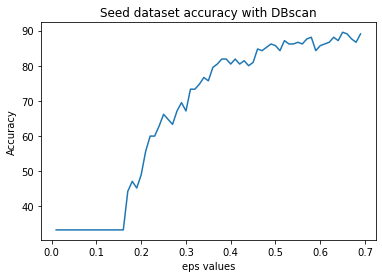

In [711]:
plt.plot([i/100 for i in range(1, 70)], accuracyResults_eps)
plt.xlabel("eps values")
plt.ylabel("Accuracy")
plt.title("Seed dataset accuracy with DBscan")

In [712]:
dbscan('../datasets/seeds.data', False, 0.6, 10)

CLUSTER: -1 ALLNUM: 188 CORRECT: 70 PRECISION: 0.3723 LABEL: 2
CLUSTER: 7 ALLNUM: 11 CORRECT: 11 PRECISION: 1.0000 LABEL: 1
CLUSTER: 162 ALLNUM: 11 CORRECT: 11 PRECISION: 1.0000 LABEL: 3


92

In [906]:
total_accuracies = []
for i in range(9, 2, -1):
    temp = []
    for j in range(31, 0, -1):
#         acc, acc_df = getAccuracy(i/10, j)
        acc = dbscan('../datasets/seeds.data', True, i/10, j)
        temp.append(round(acc/len(finalDF) * 100, 2))
    total_accuracies.append(temp)

CLUSTER: 38 ALLNUM: 35 CORRECT: 25 PRECISION: 0.7143 LABEL: 1
CLUSTER: 69 ALLNUM: 76 CORRECT: 45 PRECISION: 0.5921 LABEL: 3
CLUSTER: -1 ALLNUM: 20 CORRECT: 9 PRECISION: 0.4500 LABEL: 1
CLUSTER: 74 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 2
CLUSTER: 92 ALLNUM: 48 CORRECT: 47 PRECISION: 0.9792 LABEL: 2
CLUSTER: 209 ALLNUM: 23 CORRECT: 22 PRECISION: 0.9565 LABEL: 3
CLUSTER: 38 ALLNUM: 35 CORRECT: 25 PRECISION: 0.7143 LABEL: 1
CLUSTER: 69 ALLNUM: 76 CORRECT: 45 PRECISION: 0.5921 LABEL: 3
CLUSTER: -1 ALLNUM: 20 CORRECT: 9 PRECISION: 0.4500 LABEL: 1
CLUSTER: 74 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 2
CLUSTER: 92 ALLNUM: 48 CORRECT: 47 PRECISION: 0.9792 LABEL: 2
CLUSTER: 209 ALLNUM: 23 CORRECT: 22 PRECISION: 0.9565 LABEL: 3
CLUSTER: 38 ALLNUM: 35 CORRECT: 25 PRECISION: 0.7143 LABEL: 1
CLUSTER: 69 ALLNUM: 76 CORRECT: 45 PRECISION: 0.5921 LABEL: 3
CLUSTER: -1 ALLNUM: 20 CORRECT: 9 PRECISION: 0.4500 LABEL: 1
CLUSTER: 74 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 2
CLUSTER: 92 ALL

CLUSTER: 38 ALLNUM: 35 CORRECT: 25 PRECISION: 0.7143 LABEL: 1
CLUSTER: 69 ALLNUM: 76 CORRECT: 45 PRECISION: 0.5921 LABEL: 3
CLUSTER: 4 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 74 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 2
CLUSTER: 92 ALLNUM: 48 CORRECT: 47 PRECISION: 0.9792 LABEL: 2
CLUSTER: 30 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 209 ALLNUM: 23 CORRECT: 22 PRECISION: 0.9565 LABEL: 3
CLUSTER: -1 ALLNUM: 4 CORRECT: 3 PRECISION: 0.7500 LABEL: 3
CLUSTER: 61 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 82 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 2
CLUSTER: 38 ALLNUM: 35 CORRECT: 25 PRECISION: 0.7143 LABEL: 1
CLUSTER: 69 ALLNUM: 76 CORRECT: 45 PRECISION: 0.5921 LABEL: 3
CLUSTER: 4 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 74 ALLNUM: 8 CORRECT: 5 PRECISION: 0.6250 LABEL: 2
CLUSTER: 92 ALLNUM: 48 CORRECT: 47 PRECISION: 0.9792 LABEL: 2
CLUSTER: 30 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 209 ALLNUM: 23 COR

CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: -1 ALLNUM: 26 CORRECT: 13 PRECISION: 0.5000 LABEL: 2
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 145 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 3
CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: -1 ALLNUM: 21 CORRECT: 13 PRECISION: 0.6190 LABEL: 2
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 184 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 3
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 1

CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: 1 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 43 ALLNUM: 6 CORRECT: 3 PRECISION: 0.5000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 184 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 3
CLUSTER: 81 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 2
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: -1 ALLNUM: 7 CORRECT: 5 PRECISION: 0.7143 LABEL: 2
CLUSTER: 145 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 3
CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: 1 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 

CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUSTER: -1 ALLNUM: 67 CORRECT: 30 PRECISION: 0.4478 LABEL: 2
CLUSTER: 29 ALLNUM: 10 CORRECT: 7 PRECISION: 0.7000 LABEL: 1
CLUSTER: 123 ALLNUM: 37 CORRECT: 36 PRECISION: 0.9730 LABEL: 2
CLUSTER: 144 ALLNUM: 54 CORRECT: 50 PRECISION: 0.9259 LABEL: 3
CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUSTER: -1 ALLNUM: 67 CORRECT: 30 PRECISION: 0.4478 LABEL: 2
CLUSTER: 29 ALLNUM: 10 CORRECT: 7 PRECISION: 0.7000 LABEL: 1
CLUSTER: 123 ALLNUM: 37 CORRECT: 36 PRECISION: 0.9730 LABEL: 2
CLUSTER: 144 ALLNUM: 54 CORRECT: 50 PRECISION: 0.9259 LABEL: 3
CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUSTER: -1 ALLNUM: 67 CORRECT: 30 PRECISION: 0.4478 LABEL: 2
CLUSTER: 29 ALLNUM: 10 CORRECT: 7 PRECISION: 0.7000 LABEL: 1
CLUSTER: 123 ALLNUM: 37 CORRECT: 36 PRECISION: 0.9730 LABEL: 2
CLUSTER: 144 ALLNUM: 54 CORRECT: 50 PRECISION: 0.9259 LABEL: 3
CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUST

CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUSTER: 45 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 1
CLUSTER: 36 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 2
CLUSTER: -1 ALLNUM: 17 CORRECT: 10 PRECISION: 0.5882 LABEL: 2
CLUSTER: 29 ALLNUM: 10 CORRECT: 7 PRECISION: 0.7000 LABEL: 1
CLUSTER: 201 ALLNUM: 7 CORRECT: 4 PRECISION: 0.5714 LABEL: 3
CLUSTER: 10 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 1
CLUSTER: 123 ALLNUM: 37 CORRECT: 36 PRECISION: 0.9730 LABEL: 2
CLUSTER: 140 ALLNUM: 4 CORRECT: 3 PRECISION: 0.7500 LABEL: 3
CLUSTER: 144 ALLNUM: 54 CORRECT: 50 PRECISION: 0.9259 LABEL: 3
CLUSTER: 75 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 2
CLUSTER: 102 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 2
CLUSTER: 145 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 3
CLUSTER: 189 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 3
CLUSTER: 48 ALLNUM: 42 CORRECT: 38 PRECISION: 0.9048 LABEL: 1
CLUSTER: 45 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 1
CLUSTER: 36 ALLNUM: 1

CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 86 CORRECT: 37 PRECISION: 0.4302 LABEL: 2
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 86 CORRECT: 37 PRECISION: 0.4302 LABEL: 2
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 79 CORRECT: 37 PRECISION: 0.4684 LABEL: 2
CLUSTER: 40 ALLNUM: 7 CORRECT: 6 PRECISION: 0.8571 LABEL: 1
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
C

CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: 66 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 35 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 139 ALLNUM: 16 CORRECT: 13 PRECISION: 0.8125 LABEL: 2
CLUSTER: -1 ALLNUM: 27 CORRECT: 16 PRECISION: 0.5926 LABEL: 2
CLUSTER: 40 ALLNUM: 7 CORRECT: 6 PRECISION: 0.8571 LABEL: 1
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 10 ALLNUM: 3 CORRECT: 2 PRECISION: 0.6667 LABEL: 1
CLUSTER: 32 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 140 ALLNUM: 4 CORRECT: 3 PRECISION: 0.7500 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 165 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 1
CLUSTER: 153 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 3
CLUSTER: 107 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 2
CLUSTER: 127 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
CLUSTER: 48 ALLNUM:

CLUSTER: -1 ALLNUM: 176 CORRECT: 70 PRECISION: 0.3977 LABEL: 2
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 176 CORRECT: 70 PRECISION: 0.3977 LABEL: 2
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 176 CORRECT: 70 PRECISION: 0.3977 LABEL: 2
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 176 CORRECT: 70 PRECISION: 0.3977 LABEL: 2
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 149 CORRECT: 70 PRECISION: 0.4698 LABEL: 2
CLUSTER: 5 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 1
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 149 CORRECT: 70 PRECISION: 0.4698 LABEL: 2
CLUSTER: 5 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 1
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: -1 ALLNUM: 124 CORRECT: 45 PRECISION: 0.3629 LABEL: 2
CLUSTER: 5 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 

CLUSTER: 58 ALLNUM: 11 CORRECT: 9 PRECISION: 0.8182 LABEL: 1
CLUSTER: 5 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 31 CORRECT: 16 PRECISION: 0.5161 LABEL: 2
CLUSTER: 66 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 6 ALLNUM: 8 CORRECT: 7 PRECISION: 0.8750 LABEL: 1
CLUSTER: 26 ALLNUM: 12 CORRECT: 8 PRECISION: 0.6667 LABEL: 1
CLUSTER: 36 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 1
CLUSTER: 74 ALLNUM: 13 CORRECT: 12 PRECISION: 0.9231 LABEL: 2
CLUSTER: 196 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 3
CLUSTER: 144 ALLNUM: 34 CORRECT: 33 PRECISION: 0.9706 LABEL: 3
CLUSTER: 165 ALLNUM: 6 CORRECT: 4 PRECISION: 0.6667 LABEL: 3
CLUSTER: 156 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 3
CLUSTER: 126 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 2
CLUSTER: 106 ALLNUM: 25 CORRECT: 25 PRECISION: 1.0000 LABEL: 2
CLUSTER: 86 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 173 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 3
CLUSTER: 189 ALLNUM: 

CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 183 CORRECT: 70 PRECISION: 0.3825 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 183 CORRECT: 70 PRECISION: 0.3825 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 183 CORRECT: 70 PRECISION: 0.3825 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 183 CORRECT: 70 PRECISION: 0.3825 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 183 CORRECT: 70 PRECISION: 0.3825 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 161 CORRECT: 70 PRECISION: 0.4348 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: 91 ALLNUM: 22 CORRECT: 22 PRECISION: 1.0000 LABEL: 2
CLUSTER: -1 ALLNUM: 161 CORRECT: 70 PRECISION: 0.4348 LA

CLUSTER: 48 ALLNUM: 20 CORRECT: 20 PRECISION: 1.0000 LABEL: 1
CLUSTER: 46 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 1
CLUSTER: 35 ALLNUM: 6 CORRECT: 4 PRECISION: 0.6667 LABEL: 1
CLUSTER: 68 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 1
CLUSTER: 14 ALLNUM: 8 CORRECT: 8 PRECISION: 1.0000 LABEL: 1
CLUSTER: 25 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 32 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 1
CLUSTER: 31 ALLNUM: 3 CORRECT: 2 PRECISION: 0.6667 LABEL: 2
CLUSTER: 79 ALLNUM: 2 CORRECT: 1 PRECISION: 0.5000 LABEL: 2
CLUSTER: 43 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 1
CLUSTER: 19 ALLNUM: 9 CORRECT: 5 PRECISION: 0.5556 LABEL: 3
CLUSTER: -1 ALLNUM: 9 CORRECT: 3 PRECISION: 0.3333 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: 23 ALLNUM: 4 CORRECT: 3 PRECISION: 0.7500 LABEL: 1
CLUSTER: 27 ALLNUM: 6 CORRECT: 4 PRECISION: 0.6667 LABEL: 3
CLUSTER: 62 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 30 ALLNUM: 1 CORRECT: 1 PR

CLUSTER: 24 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 1
CLUSTER: 7 ALLNUM: 16 CORRECT: 16 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 65 CORRECT: 31 PRECISION: 0.4769 LABEL: 2
CLUSTER: 11 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 1
CLUSTER: 6 ALLNUM: 9 CORRECT: 8 PRECISION: 0.8889 LABEL: 1
CLUSTER: 69 ALLNUM: 7 CORRECT: 4 PRECISION: 0.5714 LABEL: 1
CLUSTER: 194 ALLNUM: 5 CORRECT: 4 PRECISION: 0.8000 LABEL: 3
CLUSTER: 162 ALLNUM: 20 CORRECT: 20 PRECISION: 1.0000 LABEL: 3
CLUSTER: 199 ALLNUM: 6 CORRECT: 4 PRECISION: 0.6667 LABEL: 1
CLUSTER: 154 ALLNUM: 13 CORRECT: 13 PRECISION: 1.0000 LABEL: 3
CLUSTER: 121 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 2
CLUSTER: 74 ALLNUM: 10 CORRECT: 10 PRECISION: 1.0000 LABEL: 2
CLUSTER: 106 ALLNUM: 17 CORRECT: 17 PRECISION: 1.0000 LABEL: 2
CLUSTER: 96 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 112 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 196 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 3
CLUSTER: 145 ALLNUM: 4

In [703]:
total_accuracies

[[72.86, 72.86, 72.86, 73.81, 73.81, 76.19, 76.19, 76.19, 76.19, 76.19, 77.62],
 [81.43, 81.43, 81.43, 84.76, 84.76, 84.76, 84.76, 86.19, 87.62, 87.62, 87.62],
 [76.67, 76.67, 76.67, 76.67, 76.67, 79.05, 79.05, 79.05, 79.05, 83.81, 85.24],
 [72.38, 72.38, 72.38, 72.38, 75.24, 75.24, 75.24, 75.24, 75.24, 75.24, 76.19],
 [49.05, 49.05, 49.05, 49.05, 49.05, 61.9, 61.9, 61.9, 61.9, 68.57, 68.57],
 [33.33, 33.33, 33.33, 33.33, 33.33, 46.19, 46.19, 46.19, 46.19, 46.19, 56.67],
 [33.33, 33.33, 33.33, 33.33, 33.33, 33.33, 33.33, 33.33, 33.33, 33.33, 33.33]]

Text(204.0, 0.5, 'eps (1/10)')

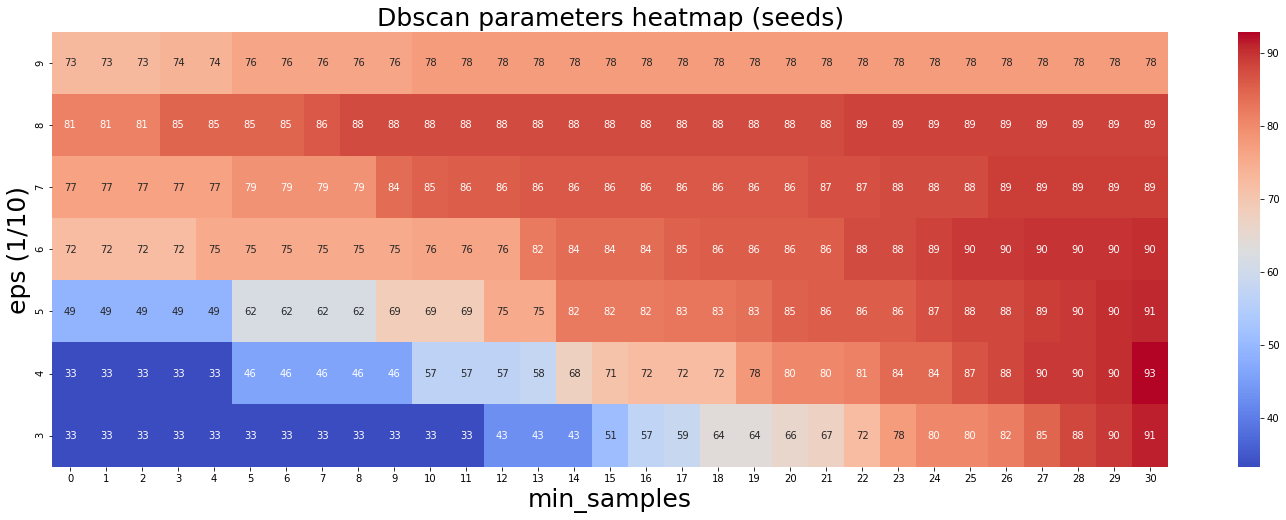

In [913]:
import seaborn as sns
plt.figure(figsize = (25,8))

ax = sns.heatmap(total_accuracies,cmap="coolwarm", annot=True)
ax.set_yticklabels([i for i in range(9, 2, -1)]) 
plt.title("Dbscan parameters heatmap (seeds)", fontsize = 25)
plt.xlabel("min_samples", fontsize = 25)
plt.ylabel("eps (1/10)", fontsize = 25)
# plt.set_yticks([i for i in range(2, 10)])

In [723]:
acc = dbscan('../datasets/seeds.data', True, 0.8, 8)
round(acc/len(finalDF) * 100, 2)

CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: 1 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 43 ALLNUM: 6 CORRECT: 3 PRECISION: 0.5000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 184 ALLNUM: 5 CORRECT: 3 PRECISION: 0.6000 LABEL: 3
CLUSTER: 81 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 2
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 77 ALLNUM: 5 CORRECT: 5 PRECISION: 1.0000 LABEL: 2
CLUSTER: 145 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 3


88.57

# Dataset = forest

In [945]:
path = 'forest'
data , attributes , value_type = process_data(path)

In [946]:
df = pd.DataFrame.from_records(data)
df.columns = attributes

In [947]:
df["class"].value_counts()

s     136
d     105
o      46
h      38
Name: class, dtype: int64

In [948]:
X = df.drop(df.columns[-1], axis=1)
Y = df.iloc[:, -1]

In [949]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
df.iloc[:, -1] = pd.factorize(df.iloc[:, -1])[0]
X_test = X
y_test = Y

In [950]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   b1                   325 non-null    float64
 1   b2                   325 non-null    float64
 2   b3                   325 non-null    float64
 3   b4                   325 non-null    float64
 4   b5                   325 non-null    float64
 5   b6                   325 non-null    float64
 6   b7                   325 non-null    float64
 7   b8                   325 non-null    float64
 8   b9                   325 non-null    float64
 9   pred_minus_obs_H_b1  325 non-null    float64
 10  pred_minus_obs_H_b2  325 non-null    float64
 11  pred_minus_obs_H_b3  325 non-null    float64
 12  pred_minus_obs_H_b4  325 non-null    float64
 13  pred_minus_obs_H_b5  325 non-null    float64
 14  pred_minus_obs_H_b6  325 non-null    float64
 15  pred_minus_obs_H_b7  325 non-null    flo

## PCA dimension reduction (to 2) for graph visualization

In [951]:
pca = PCA(n_components=2)
pca.fit(X_test)

PCA(n_components=2)

In [952]:
dfred = pca.transform(X_test)

In [953]:
finalDF = pd.DataFrame({'col 1': dfred[:, 0], 'col 2': dfred[:, 1], 'class': y_test})
# finalDF.iloc[:, -1] = finalDF.iloc[:, -1].astype('int')
finalDF.iloc[:, -1] = pd.factorize(finalDF.iloc[:, -1])[0]

In [954]:
finalDF.head()

,col 1,col 2,class
0,57.992003,-49.452329,0
1,-22.324941,-13.297553,1
2,-30.489545,-7.959191,1
3,22.672190,-18.346588,0
4,-37.908468,13.599957,1


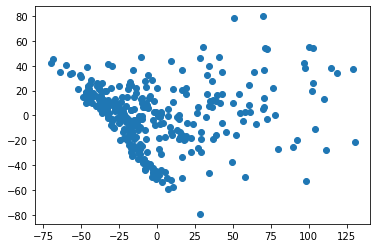

In [955]:
plt.scatter(dfred[:,0], dfred[:,1])

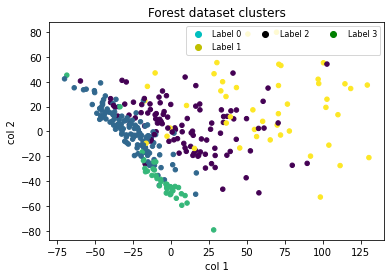

In [956]:
ax1 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c='class',
                           legend=True,
                           title="Forest dataset clusters",
                          colorbar=False,
...                       colormap='viridis')
ax1.legend([c, y, k, g],
           ('Label 0', 'Label 1', 'Label 2', 'Label 3'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

## DBscan on forest dataset


In [957]:
# Scaling the data to bring all the attributes to a comparable level
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)
  
# Normalizing the data so that 
# the data approximately follows a Gaussian distribution
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)

In [958]:
X_normalized.head()
# X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.093653,0.105599,0.053159,0.206686,0.124920,0.152677,0.367802,0.059439,0.111585,-0.079964,...,-0.079768,0.072835,-0.082656,-0.128242,0.026636,-0.257672,-0.173368,-0.131555,-0.459322,-0.412005
1,0.182135,-0.168961,-0.165664,0.060314,-0.180475,-0.055267,-0.055137,-0.043864,0.003207,-0.151089,...,0.029050,-0.010209,-0.230548,-0.253251,-0.018220,-0.185117,-0.337163,-0.229999,-0.398597,-0.483307
2,0.093528,-0.186619,-0.168078,-0.023243,-0.187776,-0.190967,-0.064276,-0.040622,-0.046530,-0.048027,...,0.071517,0.178815,-0.150953,-0.038510,0.139126,0.235412,-0.078585,-0.125901,-0.487993,-0.501127
3,0.104729,0.061070,0.025148,0.018259,0.182603,0.229649,0.371884,0.020657,0.003326,-0.067340,...,0.027641,-0.016514,-0.187710,-0.145556,0.000972,-0.008140,-0.251523,-0.237766,-0.413347,-0.490487
4,-0.167817,-0.127470,-0.124892,-0.193599,-0.108859,-0.159212,-0.096851,-0.030185,-0.052966,0.168769,...,0.084095,0.077812,-0.167949,-0.241366,0.024737,-0.307716,-0.266124,-0.157780,-0.441292,-0.439146


In [959]:
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
print(X_principal.head())

         P1        P2
0  0.484578 -0.720221
1 -0.436694 -0.562588
2 -0.445320 -0.123171
3  0.344812 -0.781073
4 -0.560828 -0.496039


In [960]:
# Numpy array of all the cluster labels assigned to each data point

# db_default = DBSCAN(eps = 0.0375, min_samples = 3).fit(X_principal)
# labels = db_default.labels_

db_default = DBSCAN(eps = 0.2575, min_samples = 30).fit(X_principal)
labels = db_default.labels_

In [961]:
labels

array([-1,  0,  0, -1,  0, -1,  0,  0,  0, -1,  0, -1,  0,  0, -1,  0, -1,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,
       -1, -1, -1,  0,  0,  1,  0, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1,
        1,  0,  0, -1,  0,  0,  1, -1, -1,  0,  0,  0,  0, -1,  0,  0, -1,
       -1,  0, -1,  0,  1,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0, -1, -1,
        0, -1,  1, -1, -1,  1, -1,  0, -1, -1, -1,  0,  0,  1, -1,  0, -1,
        0, -1,  0,  0, -1,  1,  1,  0,  1, -1,  1,  0,  0,  1,  1,  0, -1,
        0,  1, -1, -1, -1, -1,  0, -1,  0,  0,  1, -1, -1, -1, -1, -1,  0,
        1,  0, -1, -1, -1,  0,  0,  1, -1, -1,  0, -1,  0, -1, -1, -1,  1,
       -1,  1, -1,  1, -1, -1, -1,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1,
        0,  1, -1,  0,  0, -1, -1,  0, -1, -1, -1, -1,  0,  1, -1,  0,  1,
        1,  1,  0,  1, -1,  0, -1, -1,  1, -1,  0,  0, -1,  0,  1, -1, -1,
        0,  0, -1,  0,  0, -1,  1,  1, -1, -1,  0,  1, -1,  0,  0,  0,  0,
        0, -1, -1,  0, -1

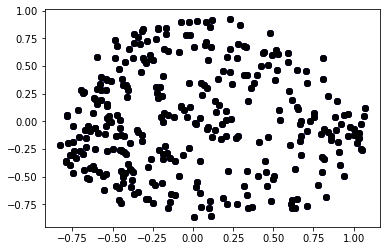

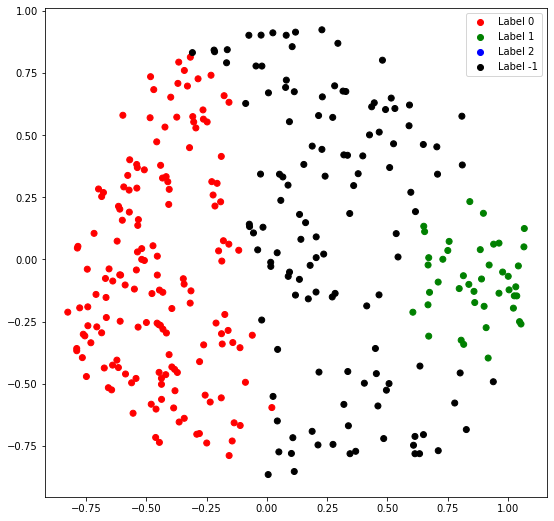

In [962]:
# Building the label to colour mapping
colours = {}
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[3] = 'y'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]
  
# For the construction of the legend of the plot
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='r');
g = plt.scatter(X_principal['P1'], X_principal['P2'], color ='g');
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b');
k = plt.scatter(X_principal['P1'], X_principal['P2'], color ='k');
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis 
# according to the colour vector defined
plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
  
# Building the legend
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1'))
  
plt.show()

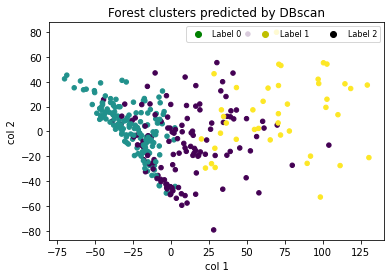

In [964]:
ax2 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c=labels,
                           legend=True,
                           title="Forest clusters predicted by DBscan",
                          colorbar=False,
...                       colormap='viridis')
ax2.legend([g, y, k],
           ('Label 0', 'Label 1', 'Label 2'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

## tuning model parameters

In [788]:
def convertClusters(arr):
    mapping = {-1: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}
    temp = []
    for i in arr:
#         temp.append(mapping[i])
        temp.append(i+1)
    return np.array(temp)

def getAccuracy(eps, min_samples):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X_principal)
    labels_1 = db.labels_
    temp_labels = convertClusters(labels_1)
    return round(accuracy_score(temp_labels, np.array(finalDF["class"]))*100, 2)

In [800]:
db = DBSCAN(eps = 0.2, min_samples = 18).fit(X_principal)
labels1 = db.labels_

In [801]:
labels1

array([-1,  0,  0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0,  0, -1,  0, -1,
        0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,
       -1, -1, -1,  0,  0,  1,  0, -1, -1, -1,  0, -1,  0,  0, -1,  0, -1,
        1,  0,  0, -1,  0, -1,  1, -1,  0,  0,  0,  0,  0, -1,  0, -1, -1,
       -1,  0,  0,  0,  1,  0,  2,  0,  0,  0,  0,  0,  2,  0,  0, -1, -1,
        0,  0,  1,  2, -1,  1, -1,  0, -1,  0,  2,  0,  0,  1,  2,  0,  2,
        0,  0,  0, -1, -1,  1,  1,  0, -1,  0,  1,  0,  0,  1,  1,  0,  0,
        0,  1, -1, -1,  0,  0,  0,  0,  0,  0,  1,  0, -1, -1,  0, -1,  0,
        1,  0, -1,  2, -1,  0,  0,  1,  0, -1,  0, -1,  0, -1,  2,  1,  1,
       -1,  1,  2,  1, -1, -1, -1,  0, -1, -1,  0,  0,  0, -1, -1,  0, -1,
        0,  1,  2,  0,  0, -1, -1,  0, -1,  0, -1, -1,  0,  1, -1,  0,  1,
        1,  1,  0,  1, -1,  0, -1, -1,  1,  2,  0, -1, -1,  0,  1,  2,  0,
        0,  0, -1,  0,  0,  0,  1,  1, -1, -1,  0,  1, -1,  0,  0,  0,  0,
        0, -1, -1,  0, -1

In [802]:
np.array(finalDF["class"])

array([0, 1, 1, 0, 1, 0, 2, 3, 1, 0, 1, 3, 0, 1, 3, 1, 3, 0, 1, 3, 3, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 3, 1, 1, 0, 0, 0, 0, 2, 3, 0, 1, 3, 3,
       1, 3, 1, 0, 2, 1, 3, 0, 2, 2, 0, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 3, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 3,
       0, 1, 3, 0, 1, 1, 1, 0, 0, 1, 0, 0, 2, 2, 0, 1, 1, 1, 0, 3, 3, 1,
       3, 0, 0, 1, 0, 3, 3, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 0, 3, 0, 0,
       1, 1, 0, 1, 3, 0, 3, 0, 0, 0, 1, 3, 1, 0, 0, 3, 1, 2, 2, 0, 3, 0,
       3, 3, 3, 0, 2, 3, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 3, 0, 1, 1, 2,
       0, 1, 0, 0, 3, 0, 1, 0, 0, 2, 0, 3, 0, 1, 3, 1, 1, 2, 0, 3, 2, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 0, 0, 0, 0, 2, 1, 0, 1,
       1, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 3, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 2,
       1, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 0, 3, 2, 0, 2, 0,
       2, 2, 0, 2, 2, 3, 1, 1, 2, 1, 1, 1, 1, 0, 1,

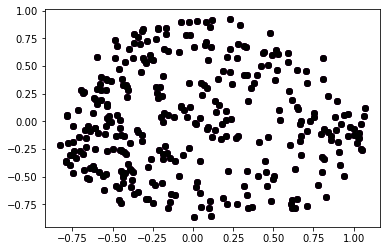

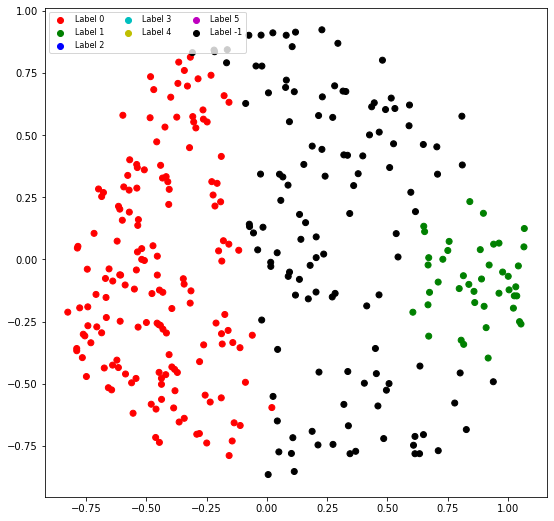

In [803]:
colours1 = {}
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'
  
cvec = [colours1[label] for label in labels]
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ]
  
r = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[0])
g = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[1])
b = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[2])
c = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[3])
y = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[4])
m = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[5])
k = plt.scatter(
        X_principal['P1'], X_principal['P2'], marker ='o', color = colors[6])
  
plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
plt.legend((r, g, b, c, y, m, k),
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5', 'Label -1'),
           scatterpoints = 1,
           loc ='upper left',
           ncol = 3,
           fontsize = 8)
plt.show()

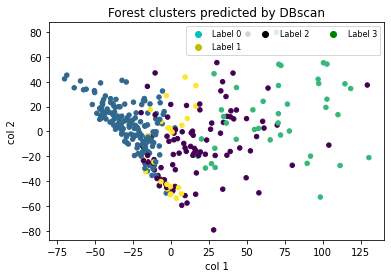

In [804]:
ax2 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c=labels1,
                           legend=True,
                           title="Forest clusters predicted by DBscan",
                          colorbar=False,
...                       colormap='viridis')
ax2.legend([c, y, k, g],
           ('Label 0', 'Label 1', 'Label 2', 'Label 3'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

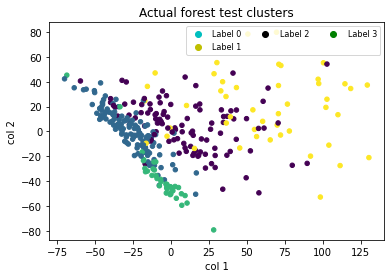

In [805]:
ax3 = finalDF.plot.scatter(x='col 1',
...                       y='col 2',
...                       c='class',
                          legend=True,
                          title="Actual forest test clusters",
                          colorbar=False,
...                       colormap='viridis')
ax3.legend([c, y, k, g],
           ('Label 0', 'Label 1', 'Label 2', 'Label 3'),
           scatterpoints = 1,
           loc ='upper right',
           ncol = 3,
           fontsize = 8)

## testing with different min_samples

In [873]:
accuracyResults_samples = []
for i in range(1, 30):
    acc = dbscan('../datasets/forest.data', True, 0.25, i)
    accuracyResults_samples.append(round(acc/len(finalDF) * 100, 2))
#     accuracyResults_samples.append(getAccuracy(0.3575, i))

CLUSTER: 55 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 48 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 66 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 7 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 1
CLUSTER: 42 ALLNUM: 6 CORRECT: 4 PRECISION: 0.6667 LABEL: 1
CLUSTER: 4 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 6 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 9 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 43 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 1
CLUSTER: 29 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 1
CLUSTER: 15 ALLNUM: 1 CORRECT: 1 PRECISION: 1.0000 LABEL: 1
CLUSTER: 19 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 1
CLUSTER: 167 ALLNUM: 7 CORRECT: 6 PRECISION: 0.8571 LABEL: 3
CLUSTER: 182 ALLNUM: 18 CORRECT: 18 PRECISION: 1.0000 LABEL: 3
CLUSTER: 179 ALLNUM: 4 CORRECT: 2 PRECISION: 0.5000 LABEL: 1
CLUSTER: 30 ALLNUM: 2 CORRECT: 2 PRECISION: 1.0000 LABEL: 1
CLUSTER: 31 ALLNUM: 3 CORRECT: 2 PREC

CLUSTER: 55 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 48 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: -1 ALLNUM: 106 CORRECT: 49 PRECISION: 0.4623 LABEL: 2
CLUSTER: 7 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 1
CLUSTER: 6 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 1
CLUSTER: 167 ALLNUM: 7 CORRECT: 6 PRECISION: 0.8571 LABEL: 3
CLUSTER: 182 ALLNUM: 18 CORRECT: 18 PRECISION: 1.0000 LABEL: 3
CLUSTER: 105 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 2
CLUSTER: 103 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 2
CLUSTER: 196 ALLNUM: 3 CORRECT: 3 PRECISION: 1.0000 LABEL: 3
CLUSTER: 154 ALLNUM: 11 CORRECT: 11 PRECISION: 1.0000 LABEL: 3
CLUSTER: 173 ALLNUM: 10 CORRECT: 10 PRECISION: 1.0000 LABEL: 3
CLUSTER: 193 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 3
CLUSTER: -1 ALLNUM: 119 CORRECT: 49 PRECISION: 0.4118 LABEL: 1
CLUSTER: 48 ALLNUM: 6 CORRECT: 6 PRECISION: 1.0000 LABEL: 1
CLUSTER: 7 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 1
CLUSTER: 167 ALLN

Text(0.5, 1.0, 'Forest dataset accuracy with DBscan')

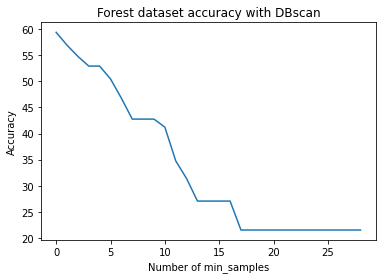

In [874]:
plt.plot(accuracyResults_samples)
plt.xlabel("Number of min_samples")
plt.ylabel("Accuracy")
plt.title("Forest dataset accuracy with DBscan")

## testing with different eps

In [875]:
accuracyResults_eps = []
for i in range(1, 30):
    acc = dbscan('../datasets/forest.data', True, i/10, 10)
    accuracyResults_eps.append(round(acc/len(finalDF) * 100, 2))
#     accuracyResults_eps.append(getAccuracy(i/10, 15))

CLUSTER: -1 ALLNUM: 210 CORRECT: 70 PRECISION: 0.3333 LABEL: 1
CLUSTER: -1 ALLNUM: 165 CORRECT: 58 PRECISION: 0.3515 LABEL: 1
CLUSTER: 7 ALLNUM: 12 CORRECT: 12 PRECISION: 1.0000 LABEL: 1
CLUSTER: 182 ALLNUM: 14 CORRECT: 14 PRECISION: 1.0000 LABEL: 3
CLUSTER: 194 ALLNUM: 7 CORRECT: 7 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 12 CORRECT: 12 PRECISION: 1.0000 LABEL: 2
CLUSTER: -1 ALLNUM: 115 CORRECT: 48 PRECISION: 0.4174 LABEL: 2
CLUSTER: 7 ALLNUM: 16 CORRECT: 16 PRECISION: 1.0000 LABEL: 1
CLUSTER: 6 ALLNUM: 9 CORRECT: 8 PRECISION: 0.8889 LABEL: 1
CLUSTER: 194 ALLNUM: 5 CORRECT: 4 PRECISION: 0.8000 LABEL: 3
CLUSTER: 162 ALLNUM: 20 CORRECT: 20 PRECISION: 1.0000 LABEL: 3
CLUSTER: 154 ALLNUM: 13 CORRECT: 13 PRECISION: 1.0000 LABEL: 3
CLUSTER: 106 ALLNUM: 17 CORRECT: 17 PRECISION: 1.0000 LABEL: 2
CLUSTER: 96 ALLNUM: 4 CORRECT: 4 PRECISION: 1.0000 LABEL: 2
CLUSTER: 190 ALLNUM: 11 CORRECT: 11 PRECISION: 1.0000 LABEL: 3
CLUSTER: 48 ALLNUM: 20 CORRECT: 20 PRECISION: 1.0000 LABEL: 1
CLUSTER:

Text(0.5, 1.0, 'Seed dataset accuracy with DBscan')

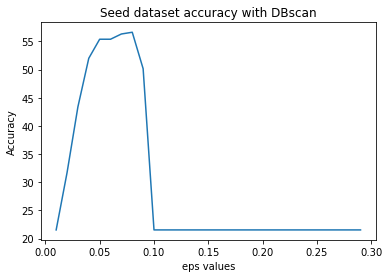

In [876]:
plt.plot([i/100 for i in range(1, 30)], accuracyResults_eps)
plt.xlabel("eps values")
plt.ylabel("Accuracy")
plt.title("Seed dataset accuracy with DBscan")

In [866]:
total_accuracies = []
for i in range(8, 1, -1):
    temp = []
    for j in range(30, 20, -1):
        acc = dbscan('../datasets/forest.data', True, i/10, j)
        temp.append(round(acc/len(finalDF) * 100, 2))
    total_accuracies.append(temp)

CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: -1 ALLNUM: 33 CORRECT: 13 PRECISION: 0.3939 LABEL: 2
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: -1 ALLNUM: 33 CORRECT: 13 PRECISION: 0.3939 LABEL: 2
CLUSTER: 138 ALLNUM: 15 CORRECT: 8 PRECISION: 0.5333 LABEL: 2
CLUSTER: 161 ALLNUM: 60 CORRECT: 54 PRECISION: 0.9000 LABEL: 3
CLUSTER: 201 ALLNUM: 10 CORRECT: 6 PRECISION: 0.6000 LABEL: 1
CLUSTER: 121 ALLNUM: 40 CORRECT: 39 PRECISION: 0.9750 LABEL: 2
CLUSTER: 97 ALLNUM: 9 CORRECT: 9 PRECISION: 1.0000 LABEL: 2
CLUSTER: 21 ALLNUM: 43 CORRECT: 42 PRECISION: 0.9767 LABEL: 1
CLUSTER: -1 ALLNUM: 26 CORRECT: 13 PRECISION: 0.5000 LABEL: 2
CLUSTER:

CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 116 CORRECT: 67 PRECISION: 0.5776 LABEL: 2
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 86 CORRECT: 37 PRECISION: 0.4302 LABEL: 2
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 86 CORRECT: 37 PRECISION: 0.4302 LABEL: 2
CLUSTER: 204 ALLNUM: 18 CORRECT: 12 PRECISION: 0.6667 LABEL: 3
CLUSTER: 183 ALLNUM: 43 CORRECT: 43 PRECISION: 1.0000 LABEL: 3
CLUSTER: 104 ALLNUM: 30 CORRECT: 30 PRECISION: 1.0000 LABEL: 2
CLUSTER: 48 ALLNUM: 33 CORRECT: 30 PRECISION: 0.9091 LABEL: 1
CLUSTER: -1 ALLNUM: 79 CORRECT: 37 PRECISION: 0.4684 LABEL: 2

In [867]:
total_accuracies[0]

[52.62, 52.62, 54.77, 54.77, 54.77, 54.77, 55.69, 56.62, 56.62, 56.62]

Text(69.0, 0.5, 'eps')

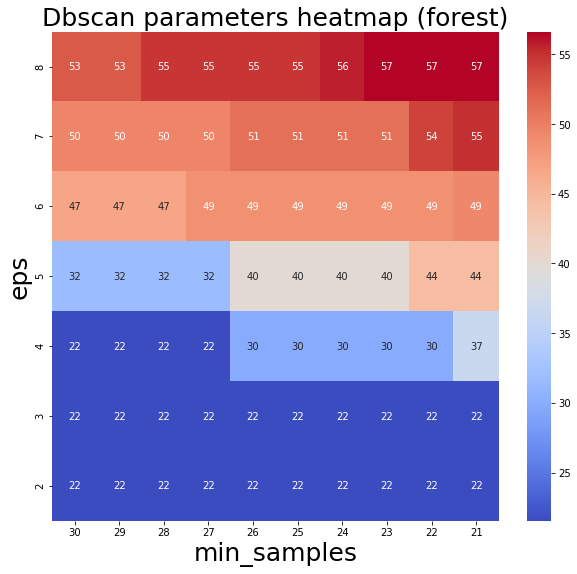

In [870]:
import seaborn as sns
plt.figure(figsize = (10,9))

ax = sns.heatmap(total_accuracies,cmap="coolwarm", annot=True)
ax.set_yticklabels([i for i in range(8, 1, -1)]) 
ax.set_xticklabels([i for i in range(30, 20, -1)]) 
plt.title("Dbscan parameters heatmap (forest)", fontsize = 25)
plt.xlabel("min_samples", fontsize = 25)
plt.ylabel("eps", fontsize = 25)

In [843]:
from collections import defaultdict
import math
import copy
dbscan('../datasets/seeds.data', True, 0.4, 21)

CLUSTER: -1 ALLNUM: 161 CORRECT: 70 PRECISION: 0.4348 LABEL: 1
CLUSTER: 144 ALLNUM: 27 CORRECT: 27 PRECISION: 1.0000 LABEL: 3
CLUSTER: 91 ALLNUM: 22 CORRECT: 22 PRECISION: 1.0000 LABEL: 2


119